# Measuring land consumption through urbanization <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
s2a_msil2a, s2b_msil2a

## Background
This notebook addresses Sustainable Development Goal (SDG) Indicator 11.3.1, which requires the calculation of land consumption rate (urbanization) to population growth rate.
Overall, the SDG 11.3.1 indicator (see below) provides a metric for determining whether or not land consumption is growing at the same rate as population.
If the indicator is above 1.0, then land is being used at a rate faster than the population is growing which may create issues with availability of agriculture land and water resources as well as deforestation. If the indicator is below 1.0, then population is growing faster than the urban extent and there will be more pressure on urban regions such as water supply, traffic, sanitation, etc. Therefore, SDG 11.3.1 is important to urban planning and decision-making.

The indicator is defined as

$$ \text{SDG}_{11.1.3} = \frac{\text{Land consumption rate}}{\text{Population growth rate}}.$$

The land consumption rate (LCR) is defined as

$$ \text{LCR} = \frac{\ln(\text{Urb}_{t+n}/\text{Urb}_{t})}{n} $$

where $\text{Urb}_{t}$ is the total area extent of the urban agglomeration in km$^2$ for past/initial year, $\text{Urb}_{(t+n)}$ is the total area extent of the urban agglomeration in km$^2$ for current/final year, and 
$n$ is the number of years between the two measurement periods.

The population growth rate (PGR) is defined as

$$ \text{PGR} = \frac{\ln(\text{Pop}_{t+n}/\text{Pop}_{t})}{n} $$

where $\text{Pop}_{t}$ is the total population within the city in the past/initial year, $\text{Pop}_{(t+n)}$ is the total population within the city in the current/final year, and 
$n$ is the number of years between the two measurement periods.

## Description
Various satellite indices can be used to measure urbanization.
This notebook takes a simple approach, which could be adapted into a more sophisticated approach for measuring the land consumption rate, and the SDG indicator when coupled with population data.
This notebook covers how to

1. Set up a dask cluster to speed up computation
2. Select an area of interest and load Sentinel-2
3. Calculate the relevant indices, NDBI and NDVI
4. Combine the indices and threshold to identify urban areas
5. Calculate the change in urban area and the corresponding land consumption rate

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import datacube
from datacube.utils.dask import start_local_dask
from datacube.utils.rio import configure_s3_access
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr
import dask
import os

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_plotting import display_map


### Set up a dask cluster

This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the dask dashboard, click on the hyperlink that prints below the cell.

In [2]:
dask.config.set({"distributed.dashboard.link": 
        os.environ.get('JUPYTERHUB_SERVICE_PREFIX', '/')+"proxy/{port}/status"})

client = start_local_dask(n_workers=2, threads_per_worker=2, memory_limit='7G')
display(client)

creds = configure_s3_access(client=client, 
                            region_name='auto')

Client Scheduler: tcp://127.0.0.1:43331 Dashboard: /user/caitlinadams/proxy/8787/status,Cluster Workers: 2 Cores: 4 Memory: 7.00 GB


### Connect to the datacube

Connect to the datacube so we can access Digital Earth Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(app='Urbanization')

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
The parameters are

* `latitude`: The latitude range to analyse (e.g. `(6.467, 6.537)`).
For reasonable loading times, make sure the range spans less than ~0.1 degrees.
* `longitude`: The longitude range to analyse (e.g. `(-1.449, -1.369)`).
For reasonable loading times, make sure the range spans less than ~0.1 degrees.
* `time`: The date range to analyse (e.g. `('2017-08-01', '2019-11-01')`).
For reasonable loading times, make sure the range spans less than 3 years.


In [4]:
# Define the area of interest
latitude = (6.801, 6.893)
longitude = (-1.440, -1.350)

# Set the range of dates for the analysis
time = ('2017-01-01', '2018-12-31')

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
display_map(x=longitude, y=latitude)

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


## Load Sentinel-2 data

In [6]:
ds = load_ard(dc=dc,
              products=['s2a_msil2a',
                        's2b_msil2a'],
              x=longitude,
              y=latitude,
              time=time,
              measurements = ['red',
                              'nir_1', 
                              'swir_1'],
              output_crs="EPSG:102022",
              align=(15, 15),
              resolution=(-20, 20),
              group_by='solar_day',
              dask_chunks={'x':100, 'y':100})

# Print output data
print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2a_msil2a
    s2b_msil2a
Applying pixel quality/cloud mask
Returning 117 time steps as a dask array
<xarray.Dataset>
Dimensions:  (time: 117, x: 475, y: 547)
Coordinates:
  * time     (time) datetime64[ns] 2017-02-26T10:37:18.460000 ... 2018-12-28T10:39:08.114000
  * x        (x) float64 -2.75e+06 -2.75e+06 -2.75e+06 ... -2.74e+06 -2.74e+06
  * y        (y) float64 7.998e+05 7.998e+05 7.998e+05 ... 7.889e+05 7.889e+05
Data variables:
    red      (time, y, x) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    nir_1    (time, y, x) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    swir_1   (time, y, x) float32 dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
Attributes:
    crs:      EPSG:102022


## Calculate relevant indices

There are a number of ways to measure urbanization.
This notebook follows the approach by [He et al.](https://www.tandfonline.com/doi/pdf/10.1080/01431161.2010.481681), which combines the normalized difference built-up index (NDBI) and the normalized difference vegetation index (NDVI) to calculate built-up index (BU) as

$$ \text{BU} = \text{NDBI} - \text{NDVI},$$

where

$$\text{NDBI} = \frac{\text{SWIR} - \text{NIR}}{\text{SWIR} - \text{NIR}},$$

$$\text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} - \text{Red}}.$$

The intuition being that urban areas will have high NDBI and low NDVI, corresponding to high BU, whereas vegetated areas will have low NDBI and high NDVI, corresponding to low BU. 
> **Note:** This interpretation specificially focuses on growth of the built environment and does not necessarily account for the growth of agricultural land usage. 
As such, this notebook gives a demonstation of a simple method to estimate the land consumption rate, but should not be treated as a comprehensive method for determining the SDG 11.1.3 index.

The next cell calculates the relevant indices as described in the equations above, adding them to the dataset.

In [7]:
ds['NDBI'] = (ds.swir_1 - ds.nir_1)/(ds.swir_1 + ds.nir_1)
ds['NDVI'] = (ds.nir_1 - ds.red)/(ds.nir_1 + ds.red)

### Resampling
The SDG 11.1.3 index focuses on measuring the change in urbanization and population over a year. 
To account for this, we calculate the median for each calendar year of the dataset in the next cell using the `xarray.resample` method.

In [8]:
ds_resampled = ds.resample(time='1Y', closed='left').median('time')

### Computing results with dask

The next step is to actually perform the calculation of the built-up index with dask, using the `xarray.load()` method.
While the step is runnning, you can view the computation by clicking on the dashboard link that appeared after setting up dask earlier in this notebook.
Please be patient while the indices are calculated.

In [9]:
ds_resampled.load()

<xarray.Dataset>
Dimensions:  (time: 2, x: 475, y: 547)
Coordinates:
  * time     (time) datetime64[ns] 2017-12-31 2018-12-31
  * x        (x) float64 -2.75e+06 -2.75e+06 -2.75e+06 ... -2.74e+06 -2.74e+06
  * y        (y) float64 7.998e+05 7.998e+05 7.998e+05 ... 7.889e+05 7.889e+05
Data variables:
    red      (time, y, x) float32 491.0 485.5 471.5 491.0 ... 675.0 571.5 522.0
    nir_1    (time, y, x) float32 3126.0 3195.0 3002.0 ... 2774.0 2794.0 2752.0
    swir_1   (time, y, x) float32 1940.5 1961.0 1780.0 ... 2022.0 1819.5 1720.0
    NDBI     (time, y, x) float32 -0.25815684 -0.26260135 ... -0.23955628
    NDVI     (time, y, x) float32 0.71522355 0.72020745 ... 0.6178518 0.6335878

### Visualising the indices

The next two cells show the median NDBI and NDVI values for the two years of our data.
Visual comparison highlights that high NDBI typically corresponds to low NDVI, highlighting the usefulness of the BU index to identify urban areas.

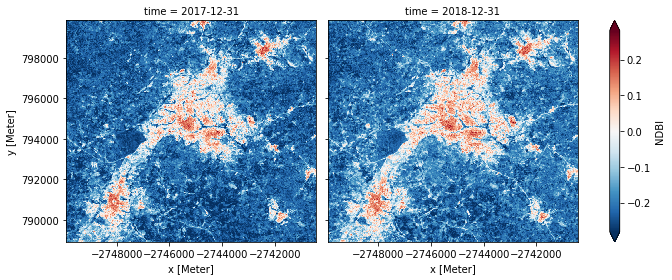

In [10]:
ds_resampled.NDBI.plot(col='time',
                       cmap='RdBu_r',
                       col_wrap=2,
                       figsize=(10,4),
                       robust=True)
plt.show()

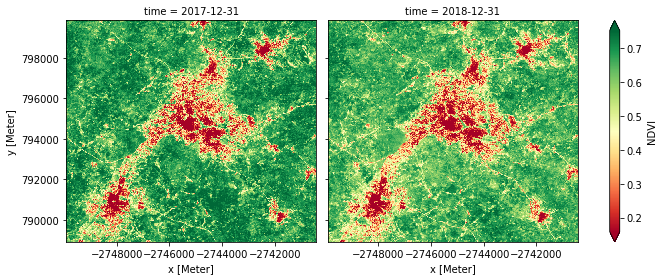

In [11]:
ds_resampled.NDVI.plot(col='time',
                       cmap='RdYlGn',
                       col_wrap=2,
                       figsize=(10,4),
                       robust=True)
plt.show()

### Calculate the built-up index

After computing the yearly medians, we can calculate the built-up index by taking the difference between the median NDBI and median NDVI.

In [12]:
ds_resampled['BU'] = ds_resampled.NDBI - ds_resampled.NDVI

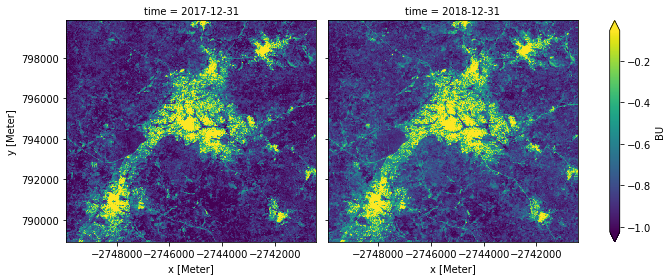

In [13]:
ds_resampled.BU.plot(col='time',
                     cmap='viridis',
                     col_wrap=2,
                     figsize=(10,4),
                     robust=True)
plt.show()

## Calculate the urban area

For the given built-up index, we need a method to decide whether a pixel is considered as "urban".
If there was classification label data available, it might be possible to train a machine learning algorithm to directly identify pixels as urban or not.
Without these labels, we can do a simple threshold to specify that pixels with BU values above the threshold are urban.
Based on the image above, we specify a threshold of $\text{BU} \geq -0.4$.
> **Note:** You may wish to experiment with the threshold value by changing it below. 
Examine the plot above to choose reasonable values.

Once the threshold is defined, the cell below classifies pixels as urban (value of 1) or non-urban (value of 0).

In [14]:
threshold = -0.4

urban = (ds_resampled.BU >= threshold).astype(int)

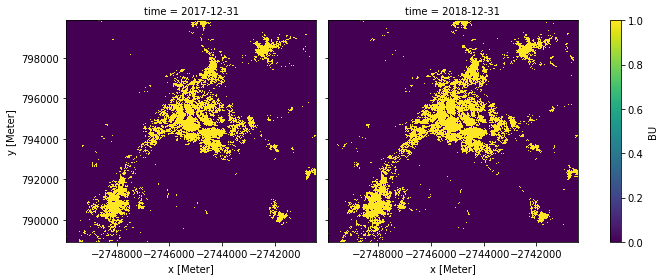

In [15]:
urban.plot(col='time',
           col_wrap=2,
           figsize=(10,4))
plt.show()

## Calculating change in urban area

The final step to estimate land consumption rate is to estimate how much land is urban. 
Given that we are taking a ratio of the total urban area for our two time steps, we can count how many pixels were classified as urban in each time step by applying the `xarray.sum` method to the `urban` dataset: 

In [16]:
urban_sum = urban.sum(dim=['x','y']).values
urban_sum

array([24507, 30231])

Then, the land consumption rate can be calculated as the logarithm of the ratio of the number of urban pixels in the second year to the first year:

In [17]:
LCR = np.log(urban_sum[1]/urban_sum[0])
LCR

0.2099090969385331

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** February 2020

**Compatible datacube version:** 

In [18]:
print(datacube.__version__)

1.7+253.ga031f3f4.dirty


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)